# Process tomography
Quantum process tomography involves
 - preparing a state
 - executing a process
 - measuring in a basis
 
The process is kept fixed, while the experimental settings ((prep, measure) tuples) are varied. You first choose a suitable set of input states and measurement operators, and then run every `itertools.product` combinations of settings.

For input states, we choose the SIC basis comprised of four states, and wee measure in the Pauli basis. The scalling w.r.t. number of qubits is therefore $4^n 3^n$, which is very exponential. If you use the $\pm$ eigenstates of the pauli operators, it scales as $6^n 3^n$.

In [1]:
import numpy as np
from pyquil import Program, get_qc
from pyquil.gates import *

## Construct a process
Which is represented as a pyQuil `Program`

In [2]:
qubits = [0]
process = Program(RX(np.pi, qubits[0]))
print(process)

RX(pi) 0



## Construct a `TomographyExperiment` for process tomography
The `I` basis measurements are redundant, and can be grouped with other terms (see below).

In [3]:
from forest.benchmarking.tomography import generate_process_tomography_experiment
experiment = generate_process_tomography_experiment(process, qubits)
print(experiment)

RX(pi) 0
0: X0_0→(1+0j)*X0
1: X0_0→(1+0j)*Y0
2: X0_0→(1+0j)*Z0
3: X1_0→(1+0j)*X0
4: X1_0→(1+0j)*Y0
5: X1_0→(1+0j)*Z0
6: Y0_0→(1+0j)*X0
7: Y0_0→(1+0j)*Y0
8: Y0_0→(1+0j)*Z0
9: Y1_0→(1+0j)*X0
10: Y1_0→(1+0j)*Y0
11: Y1_0→(1+0j)*Z0
12: Z0_0→(1+0j)*X0
13: Z0_0→(1+0j)*Y0
14: Z0_0→(1+0j)*Z0
15: Z1_0→(1+0j)*X0
16: Z1_0→(1+0j)*Y0
17: Z1_0→(1+0j)*Z0


## PyQuil will run the tomography programs

In [4]:
from pyquil.operator_estimation import measure_observables

qc = get_qc('2q-qvm')
# Over-write full quilc compilation with a much more simple
# version that *only* substitutes gates to Rigetti-native gates.
# We don't want to accidentally compile away our tomography circuit
# or map to different qubits.
from forest.benchmarking.compilation import basic_compile
qc.compiler.quil_to_native_quil = basic_compile

results = list(measure_observables(qc=qc, tomo_experiment=experiment, n_shots=1000))
results

[ExperimentResult[X0_0→(1+0j)*X0: 1.0 +- 0.0],
 ExperimentResult[X0_0→(1+0j)*Y0: 0.032 +- 0.03160658159307962],
 ExperimentResult[X0_0→(1+0j)*Z0: -0.028 +- 0.03161037804266188],
 ExperimentResult[X1_0→(1+0j)*X0: -1.0 +- 0.0],
 ExperimentResult[X1_0→(1+0j)*Y0: 0.088 +- 0.03150009523795127],
 ExperimentResult[X1_0→(1+0j)*Z0: 0.022 +- 0.031615122963543886],
 ExperimentResult[Y0_0→(1+0j)*X0: 0.024 +- 0.031613667930184886],
 ExperimentResult[Y0_0→(1+0j)*Y0: -1.0 +- 0.0],
 ExperimentResult[Y0_0→(1+0j)*Z0: 0.03 +- 0.031608543148965274],
 ExperimentResult[Y1_0→(1+0j)*X0: 0.002 +- 0.031622713356067346],
 ExperimentResult[Y1_0→(1+0j)*Y0: 1.0 +- 0.0],
 ExperimentResult[Y1_0→(1+0j)*Z0: 0.026 +- 0.031612086296225375],
 ExperimentResult[Z0_0→(1+0j)*X0: -0.05 +- 0.03158322339470751],
 ExperimentResult[Z0_0→(1+0j)*Y0: 0.068 +- 0.03154958002890054],
 ExperimentResult[Z0_0→(1+0j)*Z0: -1.0 +- 0.0],
 ExperimentResult[Z1_0→(1+0j)*X0: -0.022 +- 0.031615122963543886],
 ExperimentResult[Z1_0→(1+0j)*Y0: -0.01 

## Linear Inversion Estimate

In [5]:
from forest.benchmarking.tomography import linear_inv_process_estimate
lin_inv_process_choi_est = linear_inv_process_estimate(results, qubits)
np.real_if_close(np.round(lin_inv_process_choi_est, 2))

array([[ 0.  -0.j  , -0.01-0.03j, -0.01+0.j  , -0.  +0.02j],
       [-0.01+0.03j,  1.  -0.j  ,  1.  -0.01j,  0.01-0.j  ],
       [-0.01-0.j  ,  1.  +0.01j,  1.  +0.j  ,  0.  +0.j  ],
       [-0.  -0.02j,  0.01+0.j  ,  0.  -0.j  , -0.  +0.j  ]])

## PGDB Estimate

In [6]:
from forest.benchmarking.tomography import pgdb_process_estimate
process_choi_est = pgdb_process_estimate(results, qubits)
np.real_if_close(np.round(process_choi_est, 2))

array([[-0.  +0.j  , -0.01-0.01j, -0.01-0.01j, -0.  -0.j  ],
       [-0.01+0.01j,  1.  +0.j  ,  1.01-0.01j,  0.01+0.01j],
       [-0.01+0.01j,  1.01+0.01j,  1.  +0.j  ,  0.01+0.01j],
       [-0.  +0.j  ,  0.01-0.01j,  0.01-0.01j, -0.  -0.j  ]])

True Choi 

In [7]:
from forest.benchmarking.superoperator_tools import kraus2choi
from pyquil.gate_matrices import X as X_matrix
process_choi_ideal = kraus2choi(X_matrix)
np.real_if_close(np.round(process_choi_ideal))

array([[0., 0., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 0., 0., 0.]])

## Plot Pauli Transfer Matrix of Estimate

In [8]:
import matplotlib.pyplot as plt
from forest.benchmarking.superoperator_tools import choi2pauli_liouville
from forest.benchmarking.plotting.state_process import plot_pauli_transfer_matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_pauli_transfer_matrix(np.real(choi2pauli_liouville(process_choi_ideal)), ax1, title='Ideal')
plot_pauli_transfer_matrix(np.real(choi2pauli_liouville(process_choi_est)), ax2, title='Estimate')
plt.tight_layout()

## Two qubit example - CNOT

In [9]:
qubits = [0, 1]
process = Program(CNOT(qubits[0], qubits[1]))
experiment = generate_process_tomography_experiment(process, qubits, in_basis='sic')
print(experiment)

CNOT 0 1
0: SIC0_0 * SIC0_1→(1+0j)*X1
1: SIC0_0 * SIC0_1→(1+0j)*Y1
2: SIC0_0 * SIC0_1→(1+0j)*Z1
3: SIC0_0 * SIC0_1→(1+0j)*X0
4: SIC0_0 * SIC0_1→(1+0j)*X0X1
5: SIC0_0 * SIC0_1→(1+0j)*X0Y1
6: SIC0_0 * SIC0_1→(1+0j)*X0Z1
7: SIC0_0 * SIC0_1→(1+0j)*Y0
8: SIC0_0 * SIC0_1→(1+0j)*Y0X1
9: SIC0_0 * SIC0_1→(1+0j)*Y0Y1
... 220 not shown ...
... use e.settings_string() for all ...
230: SIC3_0 * SIC3_1→(1+0j)*X0Y1
231: SIC3_0 * SIC3_1→(1+0j)*X0Z1
232: SIC3_0 * SIC3_1→(1+0j)*Y0
233: SIC3_0 * SIC3_1→(1+0j)*Y0X1
234: SIC3_0 * SIC3_1→(1+0j)*Y0Y1
235: SIC3_0 * SIC3_1→(1+0j)*Y0Z1
236: SIC3_0 * SIC3_1→(1+0j)*Z0
237: SIC3_0 * SIC3_1→(1+0j)*Z0X1
238: SIC3_0 * SIC3_1→(1+0j)*Z0Y1
239: SIC3_0 * SIC3_1→(1+0j)*Z0Z1


In [10]:
results = list(measure_observables(qc=qc, tomo_experiment=experiment, n_shots=500))
results[:10]

[ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X1: -0.008 +- 0.04471992844359213],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Y1: 0.096 +- 0.044514806525469706],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Z1: 1.0 +- 0.0],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X0: -0.044 +- 0.0446780483011512],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X0X1: 0.08 +- 0.0445780214904161],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X0Y1: 0.012 +- 0.04471813949618208],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X0Z1: 0.02 +- 0.04471241438347967],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Y0: -0.032 +- 0.04469845634918503],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Y0X1: -0.048 +- 0.04466981083461179],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Y0Y1: -0.016 +- 0.04471563484956912]]

In [11]:
def _print_big_matrix(mat):
    for row in mat:
        for elem in row:
            elem = np.real_if_close(np.round(elem, 4), tol=.1)
            if not np.isclose(elem,0, atol=.1):
                print(f'{elem:.1f}', end=' ')
            else:
                print(' . ', end=' ')
        print()

In [12]:
lin_inv_process_choi_est = linear_inv_process_estimate(results, qubits)
_print_big_matrix(lin_inv_process_choi_est)

1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   

In [13]:
process_choi_est = pgdb_process_estimate(results, qubits)
_print_big_matrix(process_choi_est)

1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   

In [14]:
from pyquil.gate_matrices import CNOT as CNOT_matrix
process_choi_ideal = kraus2choi(CNOT_matrix)
_print_big_matrix(process_choi_ideal)

1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   

TypeError: Image data cannot be converted to float

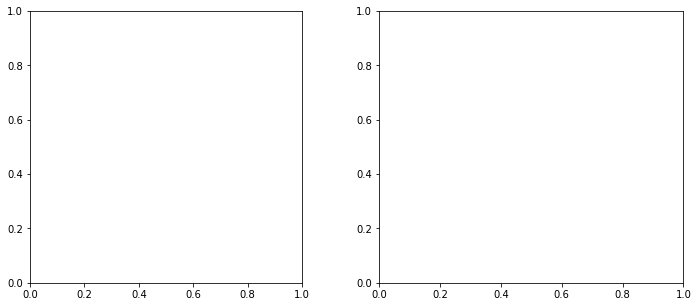

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_pauli_transfer_matrix(choi2pauli_liouville(process_choi_ideal), ax1, title='Ideal')
plot_pauli_transfer_matrix(choi2pauli_liouville(process_choi_est), ax2, title='Estimate')
plt.tight_layout()